# Visualizing GSD File

In this example, we will use `fresnel` to visualize a gsd file. We will color the particles & bonds by types, as well as visualize the simulation box.

We will need the [gsd](https://gsd.readthedocs.io/en/stable/) and [freud](https://freud.readthedocs.io/en/stable/index.html) package to run this example.

In [ ]:
import freud
import fresnel
import gsd.hoomd
import numpy as np

First we read in the `.gsd` file, then we unwrap the particle positions so the bonds are not stretched across the periodic boundary

In [2]:
with gsd.hoomd.open(name="molecules.gsd", mode="rb") as gsd_file:
    snap = gsd_file[0]

box = freud.box.Box.from_box(snap.configuration.box)
images = snap.particles.image
# Freud modifies positions in place, but we will use unwrapped_coords to be explicit 
unwrapped_coords = snap.particles.position #box.unwrap(snap.particles.position, images)

We want to color by particle type. We will color A types red, B types blue, and C types green.

In [3]:
N = snap.particles.N
particle_types = snap.particles.typeid
colors = np.empty((N, 3))

# Color by typeid
colors[particle_types == 0] = fresnel.color.linear([.95, 0, 0]) # A type
colors[particle_types == 1] = fresnel.color.linear([0, .95, 0]) # B type
colors[particle_types == 2] = fresnel.color.linear([0, 0, .95]) # C type

In [4]:
scene = fresnel.Scene()

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=N, radius=0.2)
geometry.position[:] = unwrapped_coords
geometry.material = fresnel.material.Material(roughness=0.9)
geometry.outline_width = 0.05



# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

In [5]:
# use freud box to create box in fresnel
fresnel.geometry.Box(scene, box, radius=.1)

We will visualize bonds using cylinders, and color the bonds to match the particle types. To aid visualization, we will first remove any bonds that span the periodic boundary.

In [6]:
all_bonds = np.stack(
    [
        snap.particles.position[snap.bonds.group[:, 0]],
        snap.particles.position[snap.bonds.group[:, 1]],
    ],
    axis=1,
)

# Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
bond_distances = np.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)

# This simple method will work for cubic cells
L = box.Lx
bond_indices = np.where(bond_distances < L/2)[0]
filtered_bonds = all_bonds[bond_indices, :, :]

N_bonds = filtered_bonds.shape[0]
bonds = fresnel.geometry.Cylinder(scene, N=N_bonds)
bonds.material = fresnel.material.Material(roughness=0.5)
bonds.outline_width = 0.05



# Color by bond typeid
bond_ids = snap.bonds.typeid[bond_indices]
bond_colors = np.empty((N_bonds, 3))
bond_colors[bond_ids == 0] = fresnel.color.linear([0, .95, 0])  # B-B Bonds
bond_colors[bond_ids == 1] = fresnel.color.linear([0, 0, .95])  # C-C Bonds

bonds.material.primitive_color_mix = 1.0
bonds.points[:] = filtered_bonds

bonds.color[:] = np.stack(
    [fresnel.color.linear(bond_colors), fresnel.color.linear(bond_colors)], axis=1
)
bonds.radius[:] = [0.1] * N_bonds

Now that we have everything setup, we will render everything and apply some ring lighting conditions.

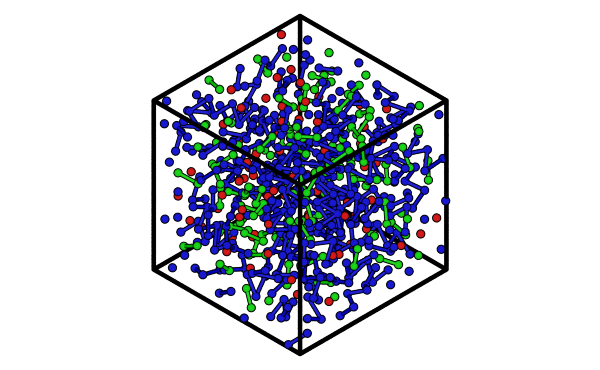

In [7]:
scene.lights = fresnel.light.ring()
fresnel.preview(scene, aa_level=3)